In [1]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import numpy as np
import math
from src.OpfModel import add_opf_constraints
from src.ThermalModel import add_indoor_constraints
from src.HHPmodel import add_hhp_constraints
from src.Model import build_model
from src.ModelConfig import Config, save_model_info
from src.Parameter import get_model_inf

In [5]:
#read the weather data from data/weather.csv
weather = pd.read_csv('data/weather.csv')
weather['timestamp'] = pd.to_datetime(weather['timestamp'])
solar = weather.loc[weather['timestamp'].dt.date == pd.Timestamp('2024-02-01').date(), ['timestamp', 'P_solar']]

# 15 min time index
time_index_15min = pd.date_range(start=solar['timestamp'].min(), 
                                 end=solar['timestamp'].max(), 
                                 freq='15min')

# reindex and interpolate
solar_15min = solar.set_index('timestamp').reindex(time_index_15min).interpolate()
solar_15min.reset_index(inplace=True)
solar_15min.rename(columns={'index': 'timestamp'}, inplace=True)
solar_output = solar_15min['P_solar'].values /1000
solar_output





array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.003 , 0.006 , 0.023 ,
       0.04  , 0.065 , 0.09  , 0.117 , 0.144 , 0.17  , 0.196 , 0.2205,
       0.245 , 0.2665, 0.288 , 0.2525, 0.217 , 0.25  , 0.283 , 0.223 ,
       0.163 , 0.1895, 0.216 , 0.186 , 0.156 , 0.204 , 0.252 , 0.2125,
       0.173 , 0.206 , 0.239 , 0.17  , 0.101 , 0.066 , 0.031 , 0.023 ,
       0.015 , 0.0075, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ])

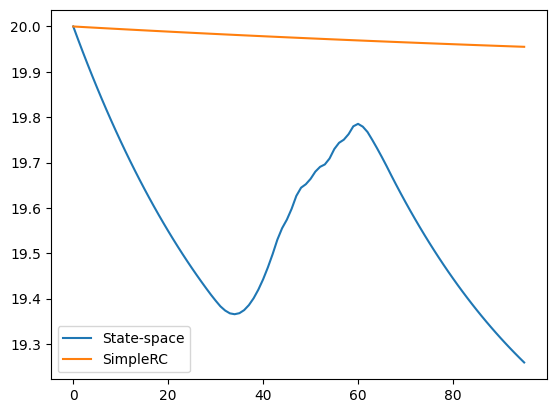

In [33]:
A=[[0.9754234372338041,0.013301970222414965,0.004636748139716821],
            [0.0034206080570929574,0.9964772560231249,8.382306645063422e-6],
            [0.20432236921074795,0.0014364106308368987,0.793524864333977]]
 

B=[[0.006637844404064138,0.0022459832989580805,0.16643854382482537],    
        [9.37536131372134e-5,2.6505141147745418e-6,0.006442730239255753],
        [0.0007163558244381842,0.8289496956732726,0.017961087687400356]]
T_ind1=[]
T_ind1.append(20)
T_h=25
T_amb=10
H=8
for t in range(95):
    T_ind1.append(A[0][0]*T_ind1[t]+A[0][1]*T_h+A[0][2]*T_amb+B[0][0]*T_amb+B[0][1]*H+B[0][2]*solar_output[t])
# T_ind1

T_ind2=[]
T_ind2.append(20)
R= 1 / (1/7 + 1/6 + 1/2)
C= 10 + 0.2 + 30
for t in range(95):
        T_ind2.append(T_ind2[t]+ (H * 0.25 + (T_amb - T_ind2[t]) / R* 0.25)/C)
# T_ind2
#compare the two models
import matplotlib.pyplot as plt
plt.plot(T_ind1,label='State-space')
plt.plot(T_ind2,label='SimpleRC')
plt.legend()

In [2]:
model_inf = get_model_inf()
Time_day =96

### State-Space Model Dynamics

The indoor temperature evolution is modeled using a state-space formulation:

$$
\mathbf{T}_{i,t+1} = \mathbf{A} \mathbf{T}_{i,t} + \mathbf{B} \mathbf{U}_{i,t}
$$

where:

- $ \mathbf{T}_{i,t} $ is the state vector at time $ t $:

$$
\mathbf{T}_{i,t} = 
\begin{bmatrix} 
T_{i,t} \\ 
T_{h,t} \\ 
T_{a,t} 
\end{bmatrix}
$$

- $ \mathbf{U}_{i,t} $ is the input vector:

$$
\mathbf{U}_{i,t} = 
\begin{bmatrix} 
T_{\text{amb},t} \\ 
\Phi_{h,i,t} \\ 
\Phi_{s,t} 
\end{bmatrix}
$$

- $ \mathbf{A} $ is the state transition matrix:

$$
\mathbf{A} =
\begin{bmatrix} 
A_{11} & A_{12} & A_{13} \\
A_{21} & A_{22} & A_{23} \\
A_{31} & A_{32} & A_{33} 
\end{bmatrix}
$$

- $ \mathbf{B} $ is the input matrix:

$$
\mathbf{B} =
\begin{bmatrix} 
B_{11} & B_{12} & B_{13} \\
B_{21} & B_{22} & B_{23} \\
B_{31} & B_{32} & B_{33} 
\end{bmatrix}
$$

- $ \mathbf{T}_{i,t} = \begin{bmatrix} T_i \\ T_h \\ T_a \end{bmatrix}_t $ represents the state variables:
  - $ T_i $: Interior temperature
  - $ T_h $: Emission system temperature
  - $ T_a $: House envelope temperature, assume to equal to ambient temperature

In [3]:

m,dict_optimizedResults = build_model(Time_day,model_inf, add_opf_constraints, add_hhp_constraints, add_indoor_constraints)



Set parameter Username
Set parameter LicenseID to value 2617326
Academic license - for non-commercial use only - expires 2026-02-03
Optimization Runtime: 3.3499999046325684 seconds
Model solved successfully!


In [ ]:
# m.setParam("LogFile", "solver_log.txt")
# m.optimize()
# Initialize configuration (custom directory and file settings)
cfg = Config(output_dir="Config", save_lp=False, save_sol=True, save_ilp=False)
# Save model information based on the configuration
save_model_info(m, cfg)

In [4]:
#change the output name

# print(dict_optimizedResults)
Result_p = dict_optimizedResults["p"]
Result_q = dict_optimizedResults["q"]
Result_v= dict_optimizedResults["v_value"]
Result_hp = dict_optimizedResults["p_hp"]
Result_pv_down = dict_optimizedResults["p_pv_down"]
Result_pv = dict_optimizedResults["p_pv"]
Result_T_ind = dict_optimizedResults["T_ind"]
Result_h_boil = dict_optimizedResults["h_boil"]
Result_PPD = dict_optimizedResults["PPD"]

In [10]:
print("total power")
print(Result_p[0])
print("Indoor Tem:")
print(Result_T_ind)
print("Gas:")
print(Result_h_boil[0])
print("hp:")
# print(Result_hp)
print(Result_hp[0])
print("PPD:")
print(Result_PPD)

total power
[-0.016142799800404284, -0.01593665315406217, -0.01595281435617647, -0.01599809817447675, -0.01609364971003991, -0.01592768535696279, -0.015930636354044417, -0.01601228164040531, -0.016098903102489636, -0.015956565973560436, -0.015963836136813167, -0.01602029577832001, -0.017074669295185425, -0.01908906707371273, -0.019372643013471604, -0.019405975931365775, -0.01935983958846895, -0.019416603624626032, -0.01930357606909304, -0.018461379466111264, -0.018014760327346897, -0.01789277840621862, -0.017994439421837455, -0.017304686528213844, -0.016696997681917913, -0.018569241699228623, -0.02106519427805091, -0.018040715118769913, -0.017254668791518796, -0.021633216470739024, -0.021304249655589767, -0.021279141188820943, -0.018100196747456453, -0.017801995745052424, -0.017831965476016932, -0.01774052819443657, -0.017388766941089723, -0.01599031276214776, -0.018837153319429343, -0.018248725265374844, -0.011680013277924855, -0.011749385287930325, -0.012493326533968232, -0.011577890

In [183]:
print(f"The optimal objective value is: {m.objVal}")

The optimal objective value is: 1144.222756733108


In [16]:
Result_p_array = np.array(Result_p)
Result_q_array = np.array(Result_q)
Result_v_array = np.array(Result_v)
for i in range(len(Result_v_array)):
    for j in range(len(Result_v_array[i])):
        Result_v_array[i][j] = math.sqrt(Result_v_array[i][j])/0.23
# Result_hp_array = np.array(Result_hp)
# Result_hp_sum = Result_hp_array.sum(axis=0)*1e3  

# Result_hp_down_array = np.array(Result_hp_down)
# Result_hp_down_sum = Result_hp_down_array.sum(axis=0)*1e3  

# Result_pv_array = np.array(Result_pv)
# Result_pv_sum = Result_pv_array.sum(axis=0)*1e3  

# Result_pv_down_array = np.array(Result_pv_down)
# Result_pv_down_sum = Result_pv_down_array.sum(axis=0)*1e3  


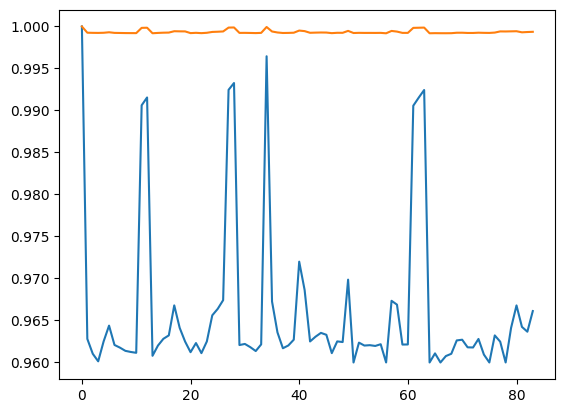

In [19]:
# for every element in Result_v_array, calculate the sqrt and /0.23 to get the p.u. voltage value

# Result_v_array
#calculate shape of the Result_v_array
#Result_v_array[i][j] calculate the min and max of each i and store in Result_v_min and Result_v_max
Result_v_min = []
Result_v_max = []
for i in range(84):
    Result_v_min.append(min(Result_v_array[i]))
    Result_v_max.append(max(Result_v_array[i]))
#plot the Result_v_min and Result_v_max
import matplotlib.pyplot as plt
plt.plot(Result_v_min)
plt.plot(Result_v_max)
plt.show()







In [25]:
#pf validate

import pandas as pd
from pandapower.plotting import simple_plot 
import pandapower as pp



def epse_feeder(t):

    net = pp.create_empty_network()
    pp.set_user_pf_options(net, algorithm='nr', init_vm_pu = "flat", init_va_degree = "dc", calculate_voltage_angles = True) 
    n_bus = 87
    # create buses
    for i in range(n_bus): 
        globals()['b{}'.format(i)] = pp.create_bus(net, 0.23, name = "b{}".format(i))          
    # slack bus
    pp.create_ext_grid(net, globals()['b0'], s_sc_max_kva=400,rx_max=0.1,r0x0_max= 0.1,x0x_max=1.0)
    # create standard lines
    # data from Vision
 
    pp.create_std_type(net, {"c_nf_per_km": 430, "r_ohm_per_km": 1.91, "x_ohm_per_km": 0.096,\
                             "c0_nf_per_km": 260, "r0_ohm_per_km": 4.65, "x0_ohm_per_km": 0.16,\
                             "max_i_ka": 0.075}, name = "16Al", element = "line")

    pp.create_std_type(net, {"c_nf_per_km": 540, "r_ohm_per_km": 0.641, "x_ohm_per_km": 0.085,\
                             "c0_nf_per_km": 320, "r0_ohm_per_km": 1.65, "x0_ohm_per_km": 0.15,\
                             "max_i_ka": 0.14}, name = "50Al", element = "line")
    pp.create_std_type(net, {"c_nf_per_km": 660, "r_ohm_per_km": 0.32, "x_ohm_per_km": 0.082,\
                             "c0_nf_per_km": 400, "r0_ohm_per_km": 0.91, "x0_ohm_per_km": 0.15,\
                             "max_i_ka": 0.22}, name = "95Al", element = "line")
    pp.create_std_type(net, {"c_nf_per_km": 200, "r_ohm_per_km": 3.061, "x_ohm_per_km": 0.1,\
                             "c0_nf_per_km": 120, "r0_ohm_per_km": 7.82, "x0_ohm_per_km": 0.18,\
                             "max_i_ka": 0.055}, name = "6Cu", element = "line")
    pp.create_std_type(net, {"c_nf_per_km": 350, "r_ohm_per_km": 1.15, "x_ohm_per_km": 0.08,\
                             "c0_nf_per_km": 210, "r0_ohm_per_km": 3.6, "x0_ohm_per_km": 0.21,\
                             "max_i_ka": 0.1}, name = "16Cu", element = "line")

    
    #use the default cable parameter, next time change it as the gaia Inom
    for i in range(n_bus-1):
        pp.create_line(net, globals()['b{}'.format(model_inf.network.at[i,'StartNode'])], \
                       globals()['b{}'.format(model_inf.network.at[i,'EndNode'])], model_inf.network.at[i,'Length']*1E-3, model_inf.network.at[i,'cable']) 
        
    # create loads
    for i in range(n_bus): 
        if i in model_inf.connect1['Node'].values:            
            pp.create_load(net, globals()['b{}'.format(i)], p_mw=Result_p_array[i][t], q_mvar=Result_q_array[i][t])
 
    # print(net.bus)
    # print(net.line)
    pp.runpp(net)
    # simple_plot(net, plot_loads = True)  
    p_bus0 = net.res_bus.loc[0, 'p_mw']  # Active power at bus 0
    q_bus0 = net.res_bus.loc[0, 'q_mvar']  # Reactive power at bus 0
    voltage_dev = np.abs(net.res_bus.vm_pu - 1)

    return net, p_bus0, q_bus0,voltage_dev

n_bus = 87
max_voltage_dev = np.zeros(n_bus)
TransAva=[]
PFdiff =[]
PF_bus0=[]
for t in range(Time_day):
    net,p_bus0,q_bus0,voltage_dev = epse_feeder(t)
    # add p_bus0 to the list
    PF_bus0.append(p_bus0)
    
    max_voltage_dev = np.maximum(max_voltage_dev, voltage_dev)
    # TransAva.append(p_bus0 - congestion_limit[t])
    # PFdiff.append(abs(p_bus0 - Result_p_array[0][t]))
        
        

use_bus_geodata is automatically set to True, since net.line_geodata is empty.


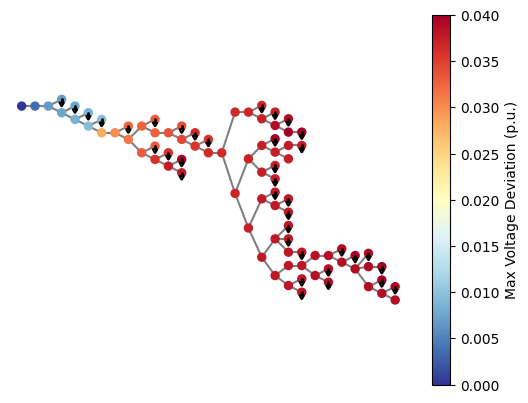

In [ ]:
import pandapower as pp
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import numpy as np

def plot_network_with_voltage_dev(net, max_voltage_dev):
    
    fig, ax = plt.subplots()
    
    # line set
    lc = plot.create_line_collection(net, lines=net.line.index, color="grey", zorder=1)
    
    # set colormap and norm
    cmap = plt.get_cmap('RdYlBu_r')  
    norm = plt.Normalize(vmin=min(max_voltage_dev), vmax=max(max_voltage_dev))
    
    # set max_voltage_dev to color
    colors = [cmap(norm(value)) for value in max_voltage_dev]
    bus_size = 0.3
    # set for bus using Musculoskeletal Disorders
    bc = plot.create_bus_collection(
        net,
        buses=net.bus.index,
        size=bus_size,
        color=colors,  # manual color
        zorder=2
    )
    
    # load collection
    collections = [lc, bc]
    if net.load.shape[0] > 0:  # check load exist
        lac = plot.create_load_collection(net, size=bus_size/2, color='black', zorder=2)
        collections.append(lac)
    
    # plot collection
    plot.draw_collections(collections, ax=ax)
    
    # add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(max_voltage_dev)
    plt.colorbar(sm, ax=ax, label='Max Voltage Deviation (p.u.)')
    plt.savefig('result/voltage_dev_plot.png', dpi=300, bbox_inches='tight')
    
    plt.show()


plot_network_with_voltage_dev(net, max_voltage_dev)

In [ ]:
model_inf.LoadPower.iloc[:,1:]
#help me sum the load power
model_inf.LoadPower.iloc[:,1:].sum(axis=1)

array([-0.01556154])

In [ ]:
# using pandapower.plotting to draw the network, and each bus 计算与标准电压的绝对差差值，标注每个点的颜色，并配上颜色棒显示出来

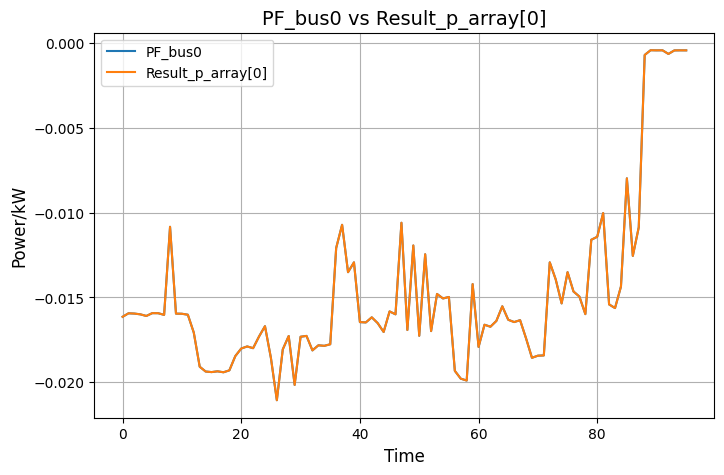

In [21]:
# compare PF_bus0 with Result_p_array[0] in every time step in a plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(PF_bus0, label='PF_bus0')
plt.plot(Result_p_array[0], label='Result_p_array[0]')
# add sum (Result_p_array[i] for i in range(1, n_bus)) to the plot
# plt.plot(-sum(Result_p_array[i] for i in range(1, n_bus)), label='Sum of Result_p_array[i]')
#plot the total load power in every time step
# plt.plot(-LoadPower.iloc[:,1:].sum(axis=1).values*1E-3, label='Total Load Power')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power/kW', fontsize=12)
plt.title('PF_bus0 vs Result_p_array[0]', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


In [136]:
#check the transformer's power 
min_value = min(TransAva)
max_value = max(PFdiff)
# Check if the transformer power of the pf fit the congestion limit
if min_value < 0:    
    locations = [i for i, val in enumerate(TransAva) if val == min_value]
    print(f"Congestion Management Error: {min_value}")
    print(f"Locations of Errors: {locations}")
#calculate the difference between the pf and opf
print(f"The power flow validate the OPF result, the biggest difference is: {max_value}MW")

The power flow validate the OPF result, the biggest difference is: 3.656321740340418e-07MW
